In [2]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [10]:
class ImageTransform():

    def __init__(self,resize,mean,std):
        self.data_transform = {
            "train":transforms.Compose([
                transforms.RandomResizedCrop(
                    resize,scale=(0.5,1.0)
                ),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            "val":transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(maen,std)
            ])
        }

    def __call__(self,img,phase="train"):
        return self.data_transform[phase](img)



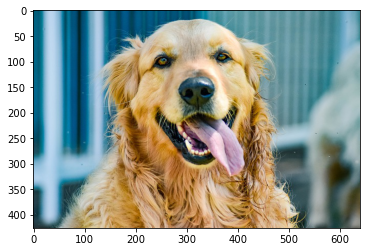

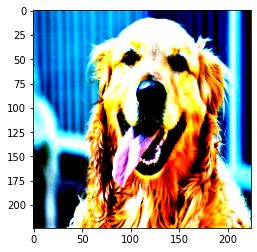

In [16]:
image_file_path = "goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)

transform = ImageTransform(size,maen,std)
img_transformed = transform(img,phase="train")

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed,0,1)

plt.imshow(img_transformed)
plt.show()

In [14]:
def make_datapath_list(phase="train"):
    rootpath = "./hymenoptera_data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")
    print(target_path)

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


[&#39;./hymenoptera_data/train/bees/1295655112_7813f37d21.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2781170484_5d61835d63.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2645107662_b73a8595cc.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2470492904_837e97800d.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2227611847_ec72d40403.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2330918208_8074770c20.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2652877533_a564830cbf.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2397446847_04ef3cd3e1.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2728759455_ce9bb8cd7a.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/98391118_bdb1e80cce.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/760568592_45a52c847f.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/17209602_fe5a5a746f.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/3030189811_01d095b793.jpg&#39;,
 &#39;./hymenoptera_data/train/bees/444532809_9e931e2

In [27]:
class HymenopteraDataset(data.Dataset):

    def __init__(self,file_list,transform = None,phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self,index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img,self.phase)

        if self.phase == "train":
            label = img_path[25:29]
        elif self.phase == "val":
            label = img_path[23:27]

        if label == "ants":
            label = 0
        if label == "bees":
            label = 1

        return img_transformed,label

train_dataset = HymenopteraDataset(file_list = train_list,transform=ImageTransform(size,mean,std),phase="train")

val_dataset = HymenopteraDataset(file_list=val_list,transform=ImageTransform(size,mean,std),phase="val")

In [28]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [29]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle = False)

dataloader_dict = {"train":train_dataloader,"val":val_dataloader}

batch_iterator = iter(dataloader_dict["train"])
inputs,labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0])


In [30]:
use_pretrained = True
net = models.vgg16(pretrained=True)

net.classifier[6] = nn.Linear(in_features=4096,out_features=2)

net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
criterion = nn.CrossEntropyLoss()

params_to_update = []

update_params_name = ["classifier.6.weight","classifier.6.bias"]

for name,param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print("---------------------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
---------------------------
[Parameter containing:
tensor([[-0.0070,  0.0066,  0.0077,  ..., -0.0116, -0.0053,  0.0037],
        [ 0.0030, -0.0092, -0.0112,  ..., -0.0114,  0.0116,  0.0057]],
       requires_grad=True), Parameter containing:
tensor([-0.0058, -0.0126], requires_grad=True)]


In [ ]:
optimizer = optim.SGD(params=params_to_update,lr=0.001,momentum=0.9)